In [84]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import time
from abc import ABC, abstractmethod
from math import atan2, cos, sin, sqrt, pi

Images folder found at: input
Found image files: ['sample2.jpg']
Checking model files in models:
  - models\res10_300x300_ssd_iter_140000.caffemodel exists: True
  - models\deploy.prototxt.txt exists: True


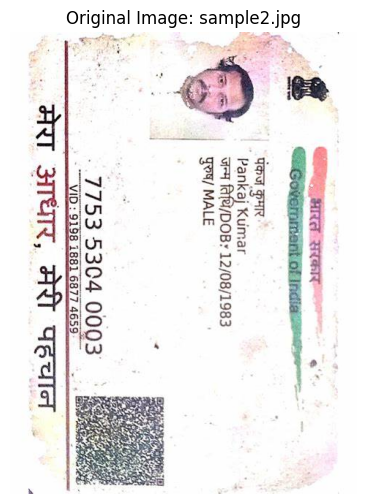

Face detected with confidence: 0.13 at index 0 (x=1975, y=2528, w=317, h=623)
Angle: 0°, Confidence: 0.13
Face detected with confidence: 0.12 at index 0 (x=2395, y=2819, w=393, h=690)
Angle: 10°, Confidence: 0.12
Face detected with confidence: 0.12 at index 0 (x=15, y=94, w=637, h=566)
Angle: 20°, Confidence: 0.12
Face detected with confidence: 0.12 at index 0 (x=116, y=3140, w=492, h=770)
Angle: 30°, Confidence: 0.12
Face detected with confidence: 0.14 at index 0 (x=331, y=321, w=245, h=274)
Angle: 40°, Confidence: 0.14
Face detected with confidence: 0.13 at index 0 (x=311, y=316, w=238, h=253)
Angle: 50°, Confidence: 0.13
Face detected with confidence: 0.61 at index 0 (x=179, y=166, w=63, h=79)
Angle: 60°, Confidence: 0.61
Face detected with confidence: 0.98 at index 0 (x=141, y=167, w=64, h=91)
Angle: 70°, Confidence: 0.98
Face detected with confidence: 0.96 at index 0 (x=98, y=166, w=64, h=82)
Angle: 80°, Confidence: 0.96
Face detected with confidence: 0.92 at index 0 (x=51, y=155,

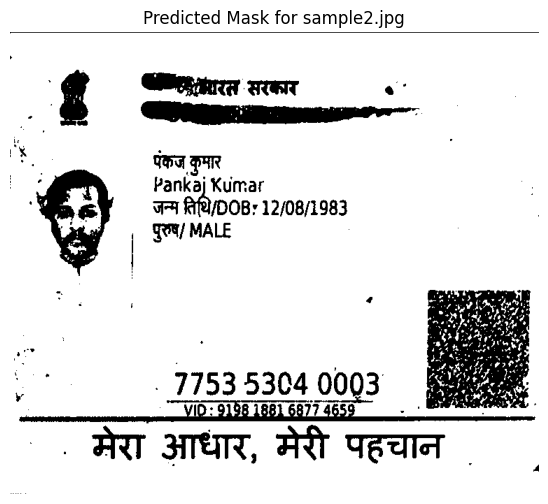

Orientation of ID Card is 20.94077364288703
Absolute orientation angle is greater than 3


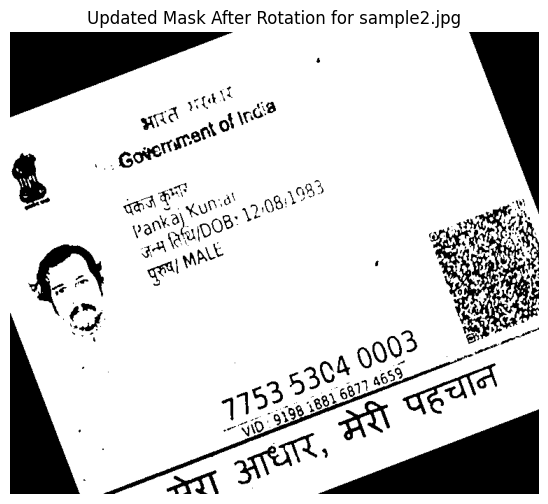

AttributeError: 'tuple' object has no attribute 'reshape'

In [87]:
# Configuration (simulating argparse defaults)
folder_name = "input"  # Adjusted to match your latest usage
rotation_interval = 10  # Finer angle checking
ORI_THRESH = 3
use_cuda = "cuda" if torch.cuda.is_available() else "cpu"
confidence_threshold = 0.3  # Increased sensitivity

# Check if images folder exists
if not os.path.isdir(folder_name):
    print(f"Error: Images folder not found at {folder_name}")
    absolute_folder = os.path.join(os.getcwd(), folder_name)
    if not os.path.isdir(absolute_folder):
        print(f"Error: Absolute path {absolute_folder} also not found")
    else:
        folder_name = absolute_folder
        print(f"Using absolute path: {folder_name}")
else:
    print(f"Images folder found at: {folder_name}")
    image_files = [f for f in os.listdir(folder_name) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Found image files: {image_files}")

# Initialize components
face_detector = face_factory(face_model="ssd", confidence_threshold=confidence_threshold).get_face_detector()
model = UnetModel(Res34BackBone(), use_cuda)

# Create preprocessed directory if it doesn't exist
preprocessed_dir = "preprocessed"
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)
    print(f"Created preprocessed directory at: {preprocessed_dir}")

# Process images
start = time.time()
for filename in sorted(os.listdir(folder_name)):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
    img_path = os.path.join(folder_name, filename)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load {filename} from {img_path}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Show original image
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(f"Original Image: {filename}")
    plt.axis("off")
    plt.show()

    # Step 1: Face Detection and Orientation
    final_img = face_detector.changeOrientationUntilFaceFound(img_rgb, rotation_interval)
    if final_img is None:
        print(f"No face detected in identity card {filename}")
        continue

    # Step 2: Perspective Correction
    final_img = correctPerspective(final_img)

    # Step 3: Segmentation and Orientation Correction
    txt_heat_map, regions = createHeatMapAndBoxCoordinates(final_img)
    txt_heat_map = cv2.cvtColor(txt_heat_map, cv2.COLOR_BGR2RGB)
    predicted_mask = model.predict(txt_heat_map)

    # Show predicted mask
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_mask, cmap="gray")
    plt.title(f"Predicted Mask for {filename}")
    plt.axis("off")
    plt.show()

    orientation_angle = findOrientationofLines(predicted_mask.copy())
    print(f"Orientation of ID Card is {orientation_angle}")
    if abs(orientation_angle) > ORI_THRESH:
        print(f"Absolute orientation angle is greater than {ORI_THRESH}")
        final_img = rotateImage(orientation_angle, final_img)
        txt_heat_map, regions = createHeatMapAndBoxCoordinates(final_img)
        txt_heat_map = cv2.cvtColor(txt_heat_map, cv2.COLOR_BGR2RGB)
        predicted_mask = model.predict(txt_heat_map)
        # Show updated mask after rotation
        plt.figure(figsize=(8, 6))
        plt.imshow(predicted_mask, cmap="gray")
        plt.title(f"Updated Mask After Rotation for {filename}")
        plt.axis("off")
        plt.show()

    # Step 4: Detect and Match Bounding Boxes
    bbox_coordinates, box_centers = getBoxRegions(regions)
    mask_centers = getCenterOfMasks(predicted_mask)
    centers_ratio_mask = getCenterRatios(predicted_mask, mask_centers)
    centers_ratio_all = getCenterRatios(final_img, box_centers)
    matched_box_indexes = matchCenters(centers_ratio_mask, centers_ratio_all)
    # Placeholder for NearestBox (not implemented due to missing file)
    new_bboxes = bbox_coordinates[matched_box_indexes] if len(bbox_coordinates) >= 4 else bbox_coordinates

    # Step 5: Visualization and Save Final Output
    final_img_with_matched_boxes = displayMachedBoxes(final_img.copy(), new_bboxes)
    final_img_with_all_boxes = displayAllBoxes(final_img_with_matched_boxes.copy(), bbox_coordinates)

    # Display the final processed image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Processed {filename} with Boxes")
    plt.imshow(final_img_with_all_boxes)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title("Final Predicted Mask")
    plt.imshow(predicted_mask, cmap="gray")
    plt.axis("off")
    plt.show()

    print(f"Detected {len(bbox_coordinates)} boxes in {filename}:")
    for i, (x, w, y, h) in enumerate(bbox_coordinates):
        print(f"Box {i+1}: x={x}, y={y}, width={w}, height={h}")

    # Step 6: Save Only the Final Processed Image
    output_filename = os.path.join(preprocessed_dir, f"processed_{filename}")
    final_img_with_all_boxes_bgr = cv2.cvtColor(final_img_with_all_boxes, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_filename, final_img_with_all_boxes_bgr)
    print(f"Saved final processed image to: {output_filename}")

end = time.time()
print(f"Execution Time: {end - start} seconds")